# Lab 7: Correlation between Vegetation Indices and Soybean Yield using Google Earth Engine

**Due**: Dec 10, 2024

In this lab, you will analyze the relationship between county-level soybean yield and various vegetation indices. We will use data from the National Agricultural Statistics Service (NASS), maintained by the USDA, which provides detailed county-level crop statistics such as yield, harvested area, planting area, and much more. You can explore this data yourself at [NASS Quick Stats](https://quickstats.nass.usda.gov/).

For this lab, I have already downloaded county-level soybean data for Illinois and Missouri for the year 2022. Your task will be to calculate zonal statistics for different vegetation indices derived from MODIS satellite imagery and then investigate their correlation with soybean yield.

I will guide you with step-by-step instructions, but the final task—creating the scatterplot and interpreting the correlation—will be up to you.

## Import modules and initialize GEE

Install libraries if needed in Google Earth Engine. If you are working in Anaconda locally, then you should create a separate environment and install packages there.

In [1]:
# install necessary packages


In [2]:
import ee
import geemap
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np

ModuleNotFoundError: No module named 'ee'

Mount the google drive (if working in colab). You will need it since you will have to read the yield data with pandas. The yield data is available in this link:

[Yield data link](https://github.com/souravbhadra/GIS5120/raw/refs/heads/main/labs/lab-7/1BBF98F1-5E9B-3A66-94BA-BCE48188EB1F.csv)

In [5]:
# mount your google drive


Authenticate and initialize the earthe engine.

In [6]:
# authenticate and initialize earthe engine


## Read Yield Data

Read the yield data you just downloaded.

In [7]:
yield_data = "read the yield data you just uploaded into your google drive"

Examine each columns. Note that, there is are several columns here which you will need later:

- `State ANSI` is the FIPS code for the state.
- `County ANSI` is the FIPS code for the county.
- `Data Item` is the the information of the `Value`.
- `Value` is the yield in Bushels/Acre unit.

**Question 1:** Create a histogram of the yield values and find the mean and standard deviation of the yield.

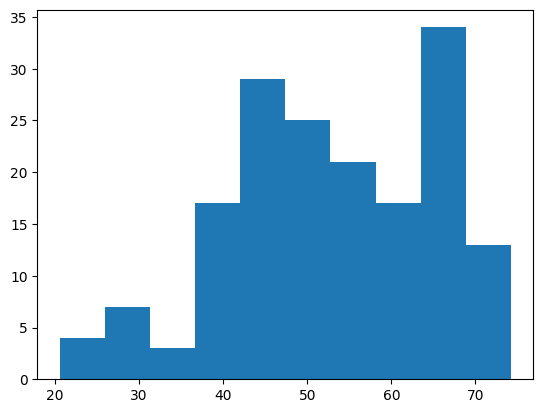

In [ ]:
# create a histogram, it should look like below

## Get County shape from GEE

We can get the US Census TIGER County shapefile directly from Google Earth Engine as FeatureCollection. But know that this is the feature collection for the entire US. So do not try to apply `getInfo()` on top of this as that could significantly take a long time to run.

In [ ]:
counties = ee.FeatureCollection('TIGER/2018/Counties')

**Question 2:** Visualize the Counties over a map. Use any type of symbologies. (Hint: Use a dictionary to stylize the shape symbology; use `addLayer` to visualize)

In [ ]:
# visualize the counties


If you want to examine the contents or attribute information of the feature collection, you have to be little creative to do that. You need to first read the first item and then get the attribute information. Its not like geopandas where you could take a peak into the entire dataframe at once. Since this is hosted in Google Earth Engine, it will take a lot of time to read the contents of an entire shape to your local memory.

In [ ]:
# read the first county
first_county = counties.first()

In [ ]:
# get the properties of the first county
properties = first_county.propertyNames().getInfo()

In [ ]:
# you can also see the values of the attributes
attributes = first_county.toDictionary().getInfo()

In [ ]:
attributes

{'ALAND': 159915148,
 'AWATER': 11211123,
 'CBSAFP': '41180',
 'CLASSFP': 'C7',
 'COUNTYFP': '510',
 'COUNTYNS': '00767557',
 'CSAFP': '476',
 'FUNCSTAT': 'F',
 'GEOID': '29510',
 'INTPTLAT': '+38.6356988',
 'INTPTLON': '-090.2445816',
 'LSAD': '25',
 'METDIVFP': '',
 'MTFCC': 'G4020',
 'NAME': 'St. Louis',
 'NAMELSAD': 'St. Louis city',
 'STATEFP': '29'}

Notice that the `STATEFP` and `COUNTYFP` information are provided in string. Also the `COUNTYFP` information is provided in three digits of string. For example, a FIPS code of 35 would be stored as '035'.

Since we have a limited list of yield data from the `yield_data` dataframe to work with, we can reduce or filter out the `counties` FeatureCollection to match with the counties of the `yield_data`. There are couple of ways to do that. We can use ee's own Filter methods to filter that. We need a list of state_fips and county_fips that can exactly match with the Feature Collection. Notice that the `yield_data`'s `County ANSI` codes are in floating data dformat. There is another problem, the `yield_data['County ANSI']` also contains some np.nan values, which is not desirable.

**Question 3:** Create a list of `state_fips` with the values of ['29', '17'] since Missouri is 29 and Illinois is 17. Create another list named `county_fips` that only contains the three digits string FIPS code from the `County ANSI` column. (Hint: Create a for loop that runs through each item of the County ANSI values. Then check if the item is nan or not, you can do that by doing `np.isnan()` method. Then, if it is not nan, convert the float to int and then to a string. If the string's length is only 2 digits, then add a 0 before it, if it's length is 1 digit, then add 00 before it.)

In [ ]:
# define state_fips
state_fips = "just use a list with the two codes"

In [ ]:
# convert the county fips using the instructions
county_fips = []
# use a for loop


Use the following codes to filter the FeatureCollection.

In [ ]:
# Filter counties by State FIPS codes
state_filter = ee.Filter.inList('STATEFP', state_fips)

# Further filter counties by County FIPS codes
county_filter = ee.Filter.inList('COUNTYFP', county_fips)

# Combine the filters
combined_filter = ee.Filter.And(state_filter, county_filter)

# Apply the filter to the counties FeatureCollection
filtered_counties = counties.filter(combined_filter)

## Extract the MODIS NDVI

Now we can use the `filtered_counties` to find the MODIS NDVI data within a given date range and then calculate the average within that time series. For this demonstration, I am selecting only one month from August and aggregating the average NDVI within that time. This would create an `ee.Image` (after doing the `mean`) from the `ee.ImageCollection`.



In [ ]:
# Filter the MODIS NDVI dataset by bounds and date range
modis_ndvi = ee.ImageCollection("MODIS/MCD43A4_006_NDVI") \
    .filterBounds(filtered_counties.geometry()) \
    .filterDate('2022-08-01', '2022-08-31') \
    .select('NDVI') \
    .mean()

We have seen before how to create a for loop and use `ee.ReduceRegion()` to perform zonal statistics. Luckily, `geemap` has a `zonal_stats` function that exactly does that within a line. The only drawback is that it must be passed with a output csv file path where the data will be saved. You can provide any path in your google drive with specific name.

In [ ]:
out_modis_stats = "your output path"

In [ ]:
# Perform zonal statistics
geemap.zonal_stats(
    modis_ndvi, # ee Image
    filtered_counties,  # Vector data (counties)
    out_file_path=out_modis_stats,  # Output file
    statistics_type='MEAN',  # Calculate mean NDVI
    scale=500,  # MODIS spatial resolution
    return_fc=False  # Export as a CSV, not a FeatureCollection
)

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/GIS5120/lab-7/zonal_stats.csv


**Question 4:** Read the newly created zonal statistics csv file. See that the `mean` column has the mean NDVI values. Look at its histogram. See that there could be one or multiple outliers in the data. Find those rows and somehow remove those rows from the dataframe.

In [ ]:
zonal_stat_df = "read the data"

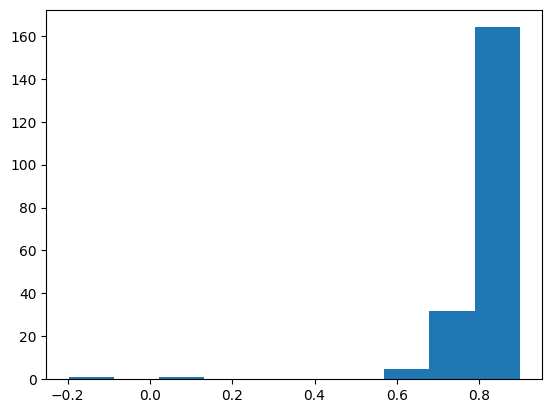

In [ ]:
# create the histogram, should look something like this


In [ ]:
# remove the outliers


**Question 5:**  See that there are `STATEFP` and `COUNTYFP` columns in the zonal statistics dataframe, whereas the `yield_data` has the `State ANSI` and `County ANSI` columns to match. You need to join these two dataframes because we want to calculate the correlation between the yield values and mean NDVI values. The unique ID to join would be the combination of state and county FIPS. (Hint: You can use the `pd.merge` function to do the joining. The left dataframe should be the `zonal_stat` as that is the base and right one can be the `yield_data`. You can also use mutiple ids here to joine the two dataframes. Note that, both state and county FIPS are needed to join because one county FIPs code can be same for the two different states.)

**Question 6:** Create a scatterplot where the mean NDVI values are in the x-axis and the yield values are in the y-axis.

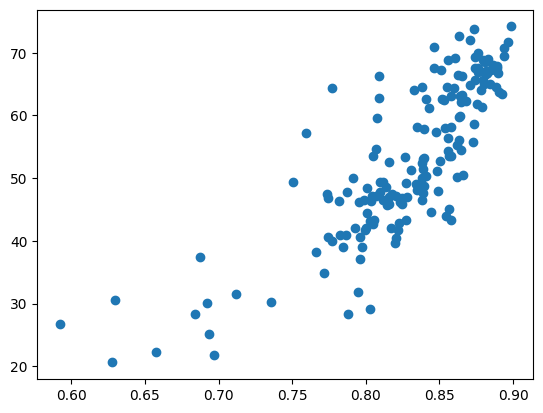

In [ ]:
# should look like something below

**Question 7:** Import the `scipy` packages. Use the `scipy.stats.pearsonr` function to calculate the Pearson's Correlation Coefficient. This will give you both the correlation coefficient and the p-value. The R should be around 0.82.

**Question 8:** Perform the similar task for the following months of 2022 using the MODIS data. Use May, June, July, August, September, and October NDVI. Remove any outliers if present (You can use some type of condition like any NDVI values less than 0.2 is outlier) and calculate the pearson's R for each of these months. Show the scatterplot for each of the months and in a text mention which month's NDVI has the highest correlation with yield.

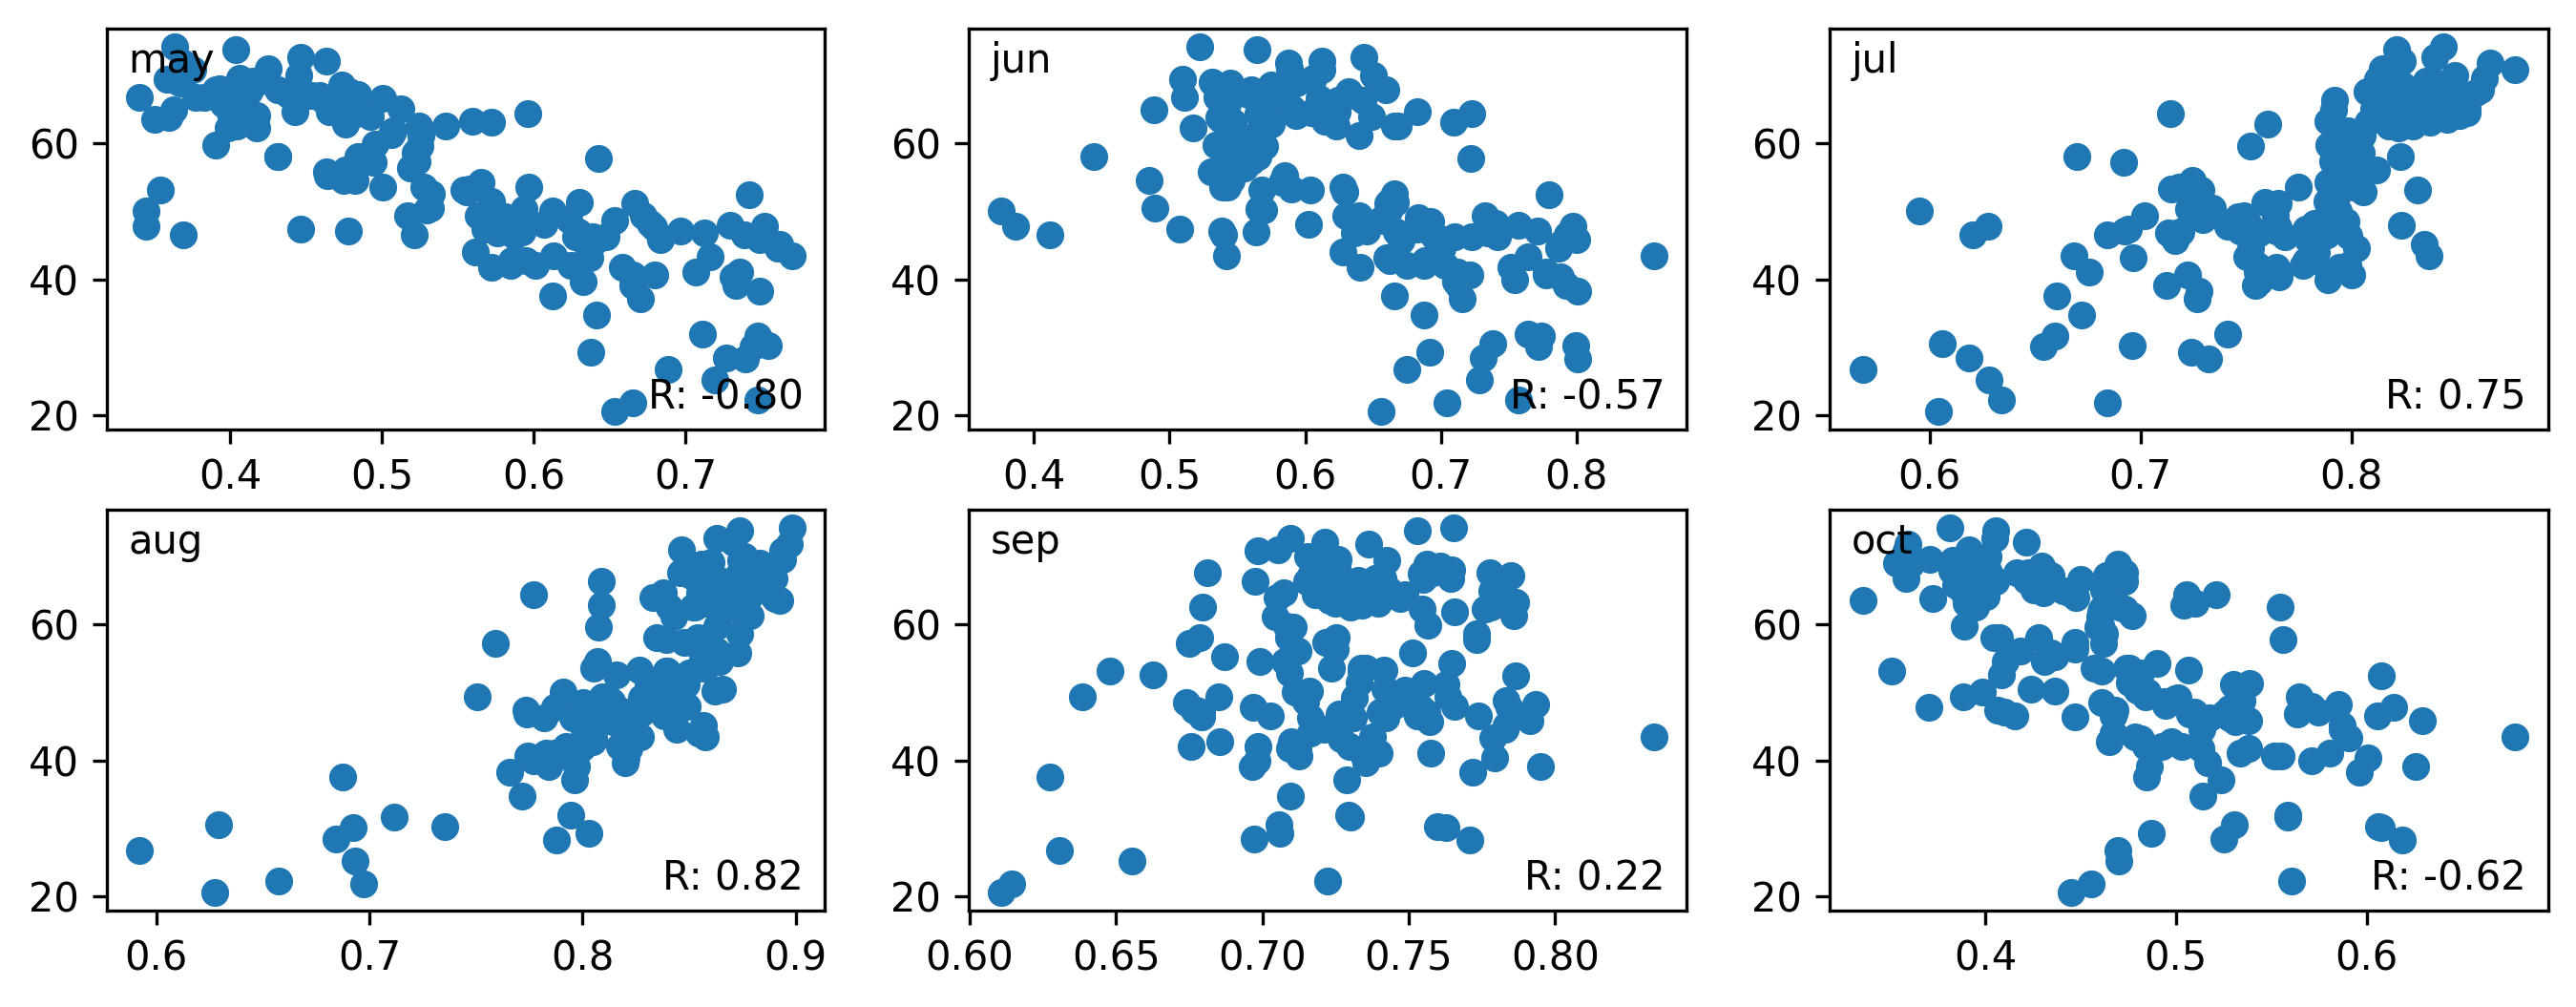

In [ ]:
# should look like something like this

## Deliverables
Submit this entire notebook in canvas after filling everything up.